In [1]:
# The following code is based on https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

import pandas as pd
pd.options.display.max_columns = None
from datetime import datetime

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

df = pd.read_csv('../../output/cut-data.csv', usecols=['dates', 'occupancy'], index_col=0, parse_dates=[0])
df.index.freq = 'D'
df

,occupancy
dates,
2017-05-01,139
2017-05-02,135
2017-05-03,133
2017-05-04,133
2017-05-05,135
...,...
2019-03-27,129
2019-03-28,141
2019-03-29,142


In [3]:
import matplotlib.pyplot as plt

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

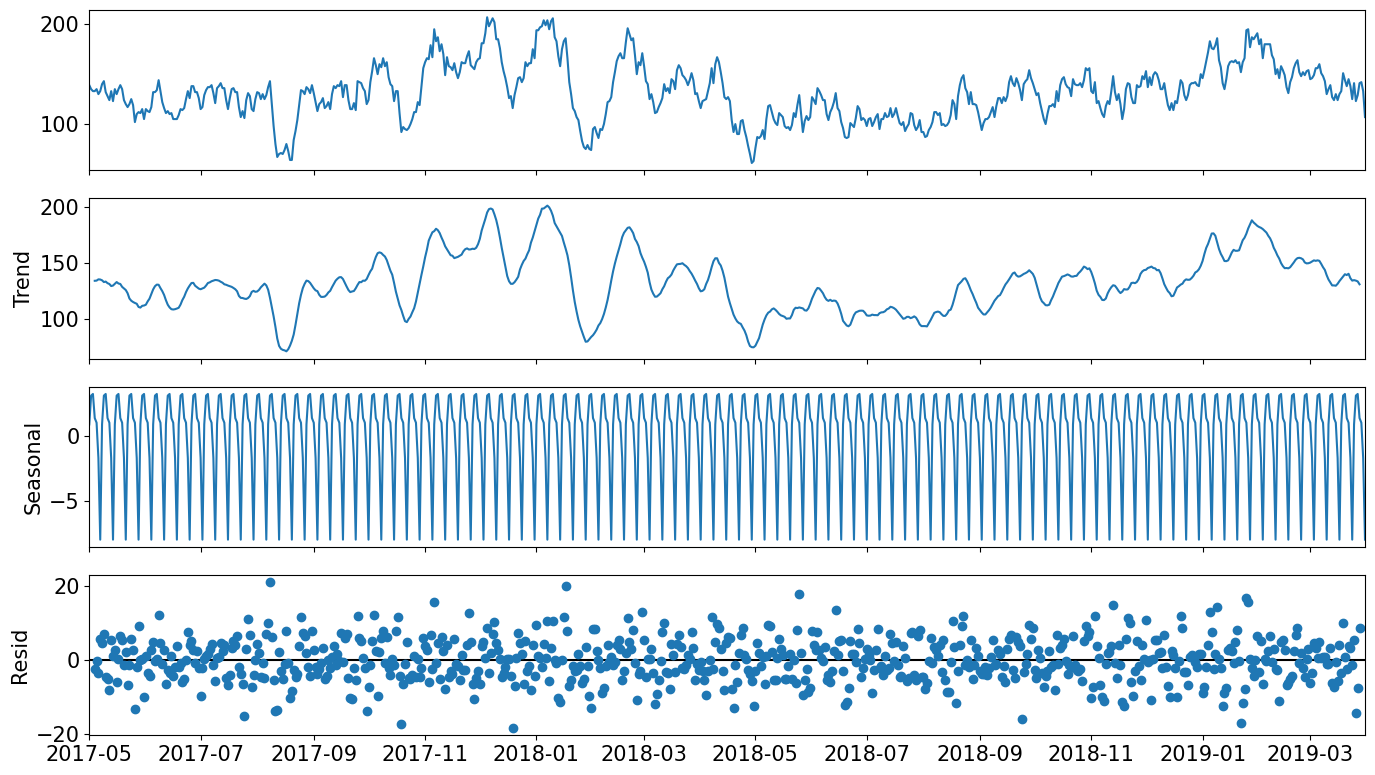

In [5]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df,model='additive')
fig = result.plot()

In [6]:
import pymannkendall as mk

In [7]:
print(mk.original_test(df, alpha=0.05))

Mann_Kendall_Test(trend='increasing', h=True, p=6.737532587508532e-05, z=3.985369051279013, Tau=0.10066625791947681, s=24628.0, var_s=38184396.666666664, slope=0.01956521739130435, intercept=124.16195652173913)


In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

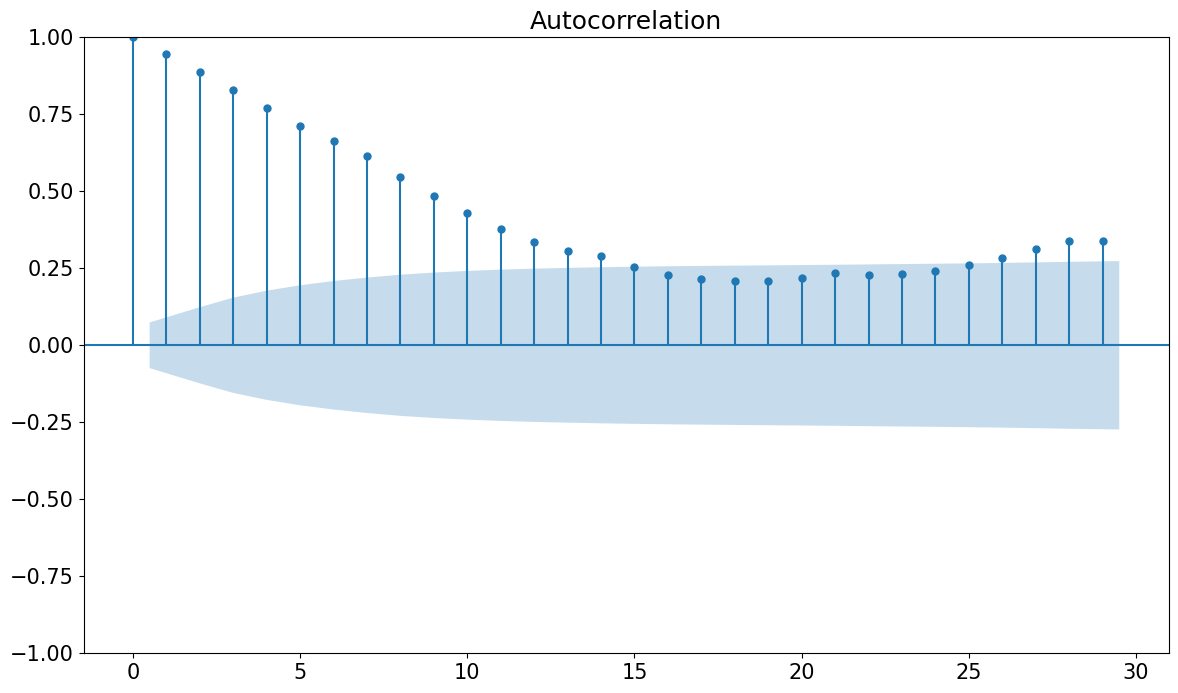

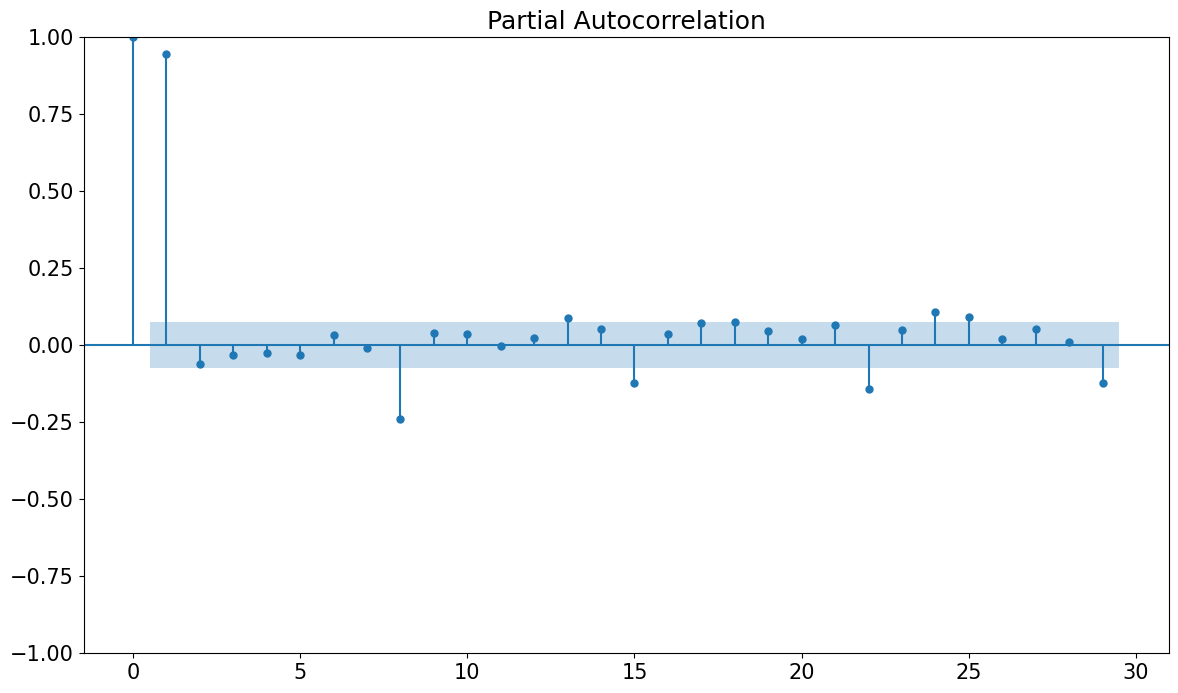

In [10]:
plot_acf(df['occupancy']);
plot_pacf(df['occupancy']);

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
# dickey-fuller test
# check if data is stationary
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

check_stationarity(df['occupancy'])

The series is stationary


In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
# p <= 2 because first 2 lags are meaningful according to PACF
# d = 0 because data is stationary
# q <= 14 because first 14 lags are meaningful according to ACF, q = 13, because of Maximum-Likelihood-Error notification if q = 14
p, d, q = 2, 0, 13

arima = ARIMA(df['occupancy'], order=(p,d,q)) 
model_fit = arima.fit()
predictions = arima.fit().predict()

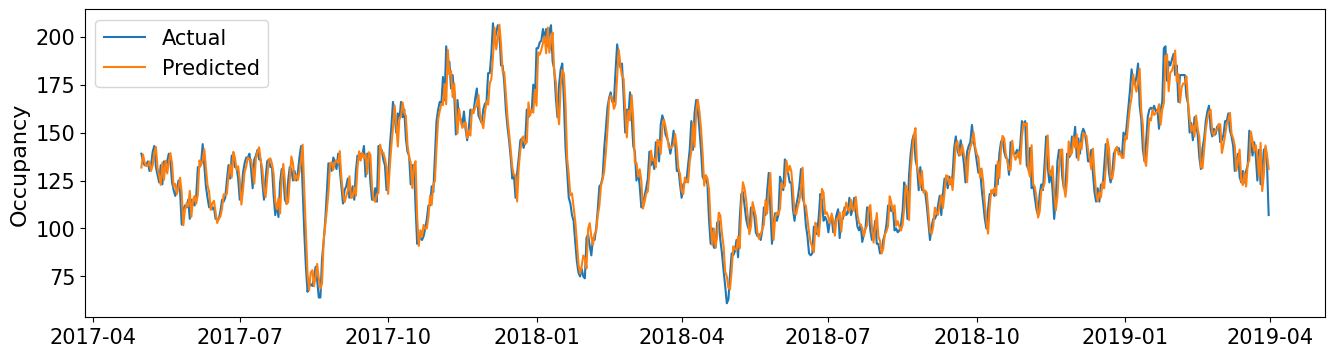

In [18]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual") # No diff because we are working with stationary data
plt.plot(predictions, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

In [21]:
rmse = root_mean_squared_error(df, predictions)
mape = mean_absolute_percentage_error(df, predictions)
[rmse, mape]

[8.574545046336578, 0.054302218861091905]

In [22]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# SARIMA

sarima = SARIMAX(df['occupancy'],
                order=(1,0,1),
                seasonal_order=(2,0,13,7))
sarima_predictions = sarima.fit().predict()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95690D+00    |proj g|=  5.40661D-01


 This problem is unconstrained.



At iterate    5    f=  3.52789D+00    |proj g|=  2.83135D-02

At iterate   10    f=  3.50049D+00    |proj g|=  6.61448D-03

At iterate   15    f=  3.49854D+00    |proj g|=  7.51152D-03

At iterate   20    f=  3.49843D+00    |proj g|=  1.75134D-03

At iterate   25    f=  3.49799D+00    |proj g|=  3.91852D-03

At iterate   30    f=  3.49659D+00    |proj g|=  7.38606D-03

At iterate   35    f=  3.49369D+00    |proj g|=  2.41291D-02

At iterate   40    f=  3.49283D+00    |proj g|=  1.65844D-03

At iterate   45    f=  3.49103D+00    |proj g|=  2.18368D-02


/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.49015D+00    |proj g|=  2.94909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     57      1     0     0   2.949D-03   3.490D+00
  F =   3.4901489724829999     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


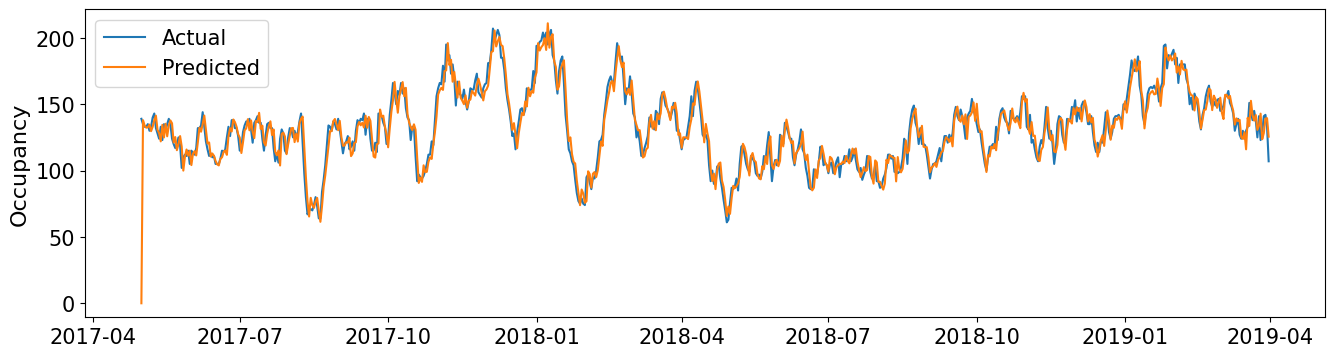

In [24]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual")
plt.plot(sarima_predictions, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [25]:
rmse = root_mean_squared_error(df, sarima_predictions)
mape = mean_absolute_percentage_error(df, sarima_predictions)
[rmse, mape]

[9.462278441723807, 0.050913224736454925]

In [26]:
# Splitting data into test and training data

train_data = df.iloc[:-30]
test_data = df.iloc[-30:]

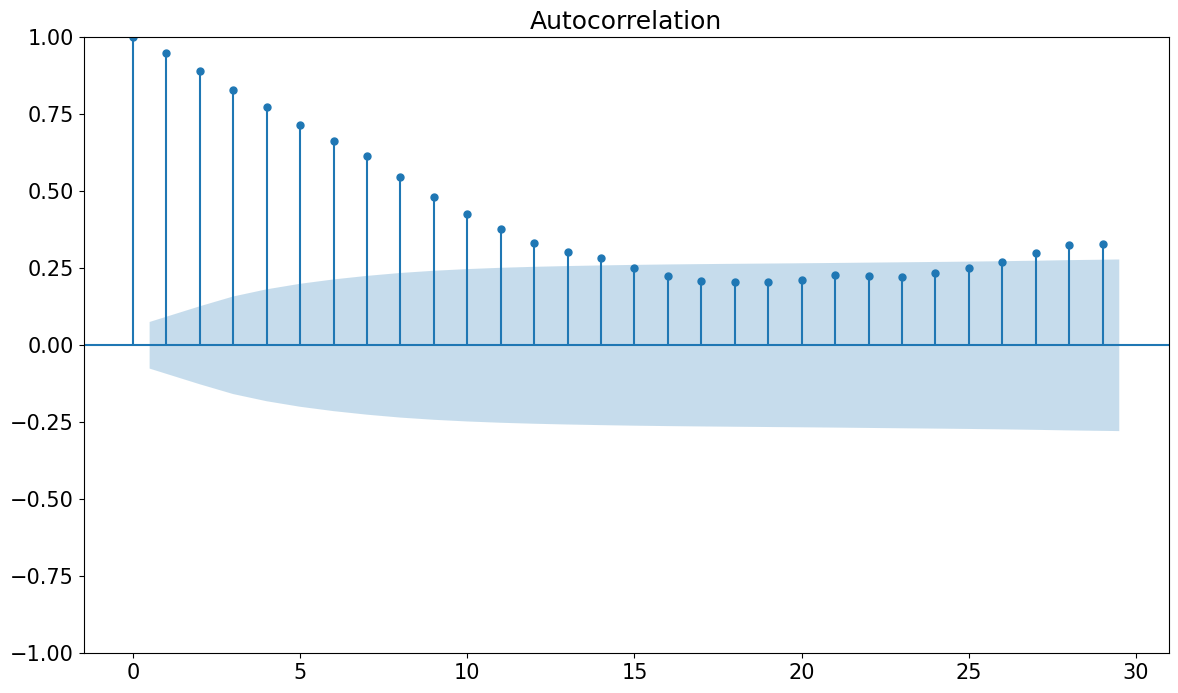

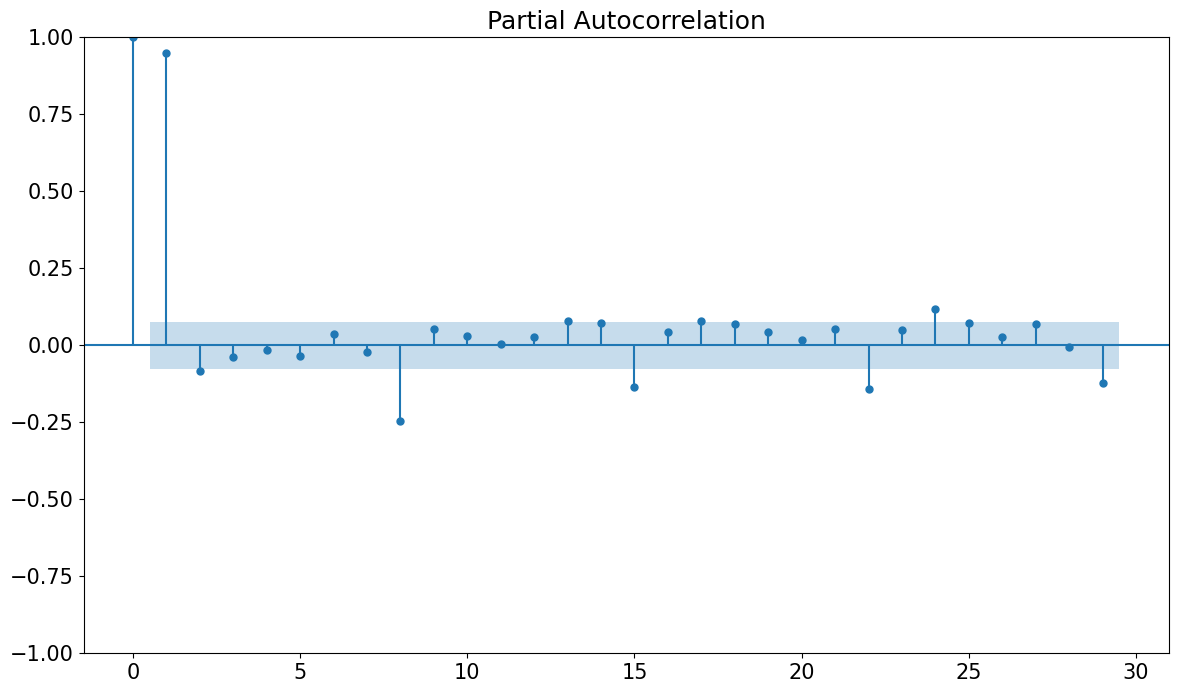

In [27]:
plot_acf(train_data['occupancy']);
plot_pacf(train_data['occupancy']);

In [29]:
# p <= 2 because first 2 lags are meaningful according to PACF
# d = 0 because data is stationary
# q <= 14 because first 14 lags are meaningful according to ACF, q = 13, because of Maximum-Likelihood-Error notification if q = 14
p, d, q = 2, 0, 13

arima_train_data = ARIMA(train_data['occupancy'], order=(p,d,q))
model_fit_train_data = arima_train_data.fit()

forecast_steps = 30
forecast_train_data = model_fit_train_data.forecast(steps=forecast_steps)

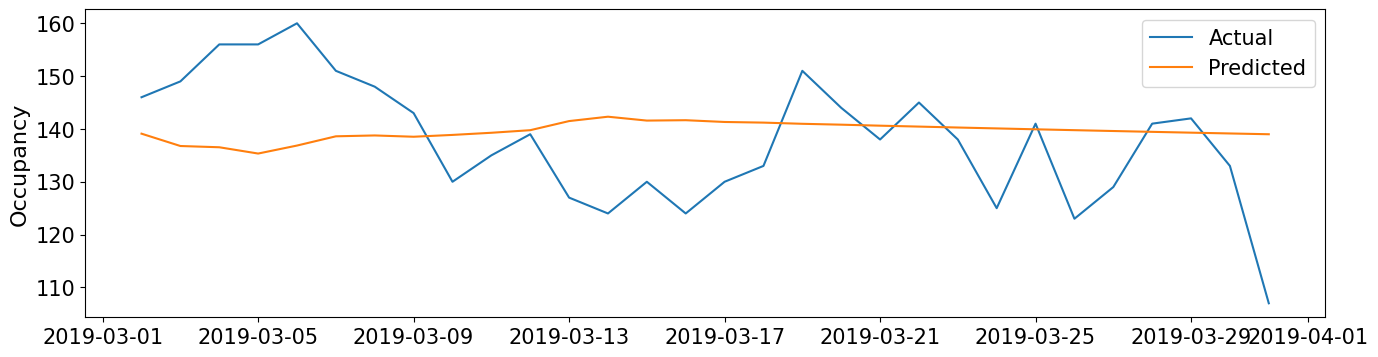

In [30]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(forecast_train_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [31]:
rmse = root_mean_squared_error(test_data[:30], forecast_train_data)
mape = mean_absolute_percentage_error(test_data[:30], forecast_train_data)
[rmse, mape]

[12.80481813336992, 0.07772818339795845]

In [32]:
# SARIMA

sarima = SARIMAX(train_data['occupancy'],
                order=(1,0,1),
                seasonal_order=(2,0,13,7))
model_fit_sarima = sarima.fit()

forecast_steps = 30
sarima_predictions_trained_data = model_fit_sarima.forecast(steps=forecast_steps)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12836D+00    |proj g|=  7.65163D-01


 This problem is unconstrained.



At iterate    5    f=  3.75681D+00    |proj g|=  2.33091D-01

At iterate   10    f=  3.70914D+00    |proj g|=  8.72908D-02

At iterate   15    f=  3.70274D+00    |proj g|=  9.59709D-03

At iterate   20    f=  3.70169D+00    |proj g|=  9.38705D-03

At iterate   25    f=  3.68590D+00    |proj g|=  2.06990D-01

At iterate   30    f=  3.53506D+00    |proj g|=  4.95166D-02

At iterate   35    f=  3.50632D+00    |proj g|=  6.60015D-02

At iterate   40    f=  3.49581D+00    |proj g|=  1.42591D-02

At iterate   45    f=  3.49458D+00    |proj g|=  1.60030D-03


/Users/alexandervalerian/Informatik/tha/intelligent-planning-of-care-staff/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.49457D+00    |proj g|=  1.81497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     59      1     0     0   1.815D-03   3.495D+00
  F =   3.4945670205583785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


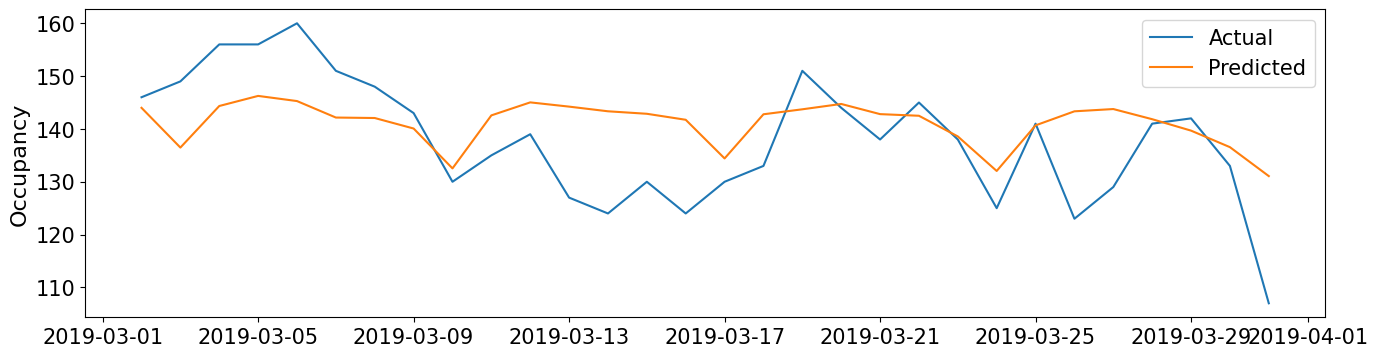

In [33]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(sarima_predictions_trained_data, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()

In [39]:
rmse = root_mean_squared_error(test_data[:30], sarima_predictions_trained_data)
mape = mean_absolute_percentage_error(test_data[:30], forecast_train_data)
[rmse, mape]

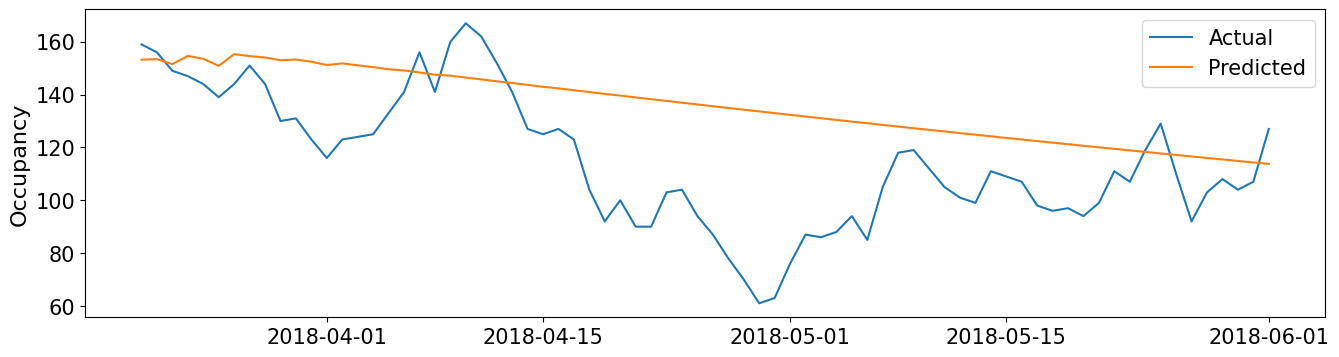

In [40]:
plt.figure(figsize=(16,4))
plt.plot(test_data, label="Actual") # No diff because we are working with stationary data
plt.plot(forecast_train_data_whole_test_data_sarima, label="Predicted")
plt.ylabel('Occupancy', fontsize=16)
plt.legend()